<a href="https://colab.research.google.com/github/moridin04/CCRNFLRL_PROJECT_COM221ML/blob/main/Hangman_DQN_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Training Hangman Agent using Deep Q-Learning**

**Installation and Import**

In [1]:
!pip install --upgrade --pre "gymnasium[atari]" ale-py

import random
import numpy as np
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video, HTML
import cv2
import base64

### **Frame Stack**

Creating a stack constructor of the most recent game frames.

It initializes FrameStack with a stack size of 4, and uses a double-ended queue to efficiently store frames, maintaining a fixed size.

For the **reset method**, it clears the frame stack, then fills it with initial state 4 times (per stack size), ensuring that the stack is full from the episode's beginning.

For the **append method**, this adds a new state to the stack. The double-ended queue was assigned a max-length set of 4. With this, adding a new frame removes the oldest frame if the stack is full.

The stacked frames are then returned as a NumPy array, with the frames stacked along a new dimension of axis 0 (a format expected by the Neural Network).

In [2]:
class FrameStack:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)

    def reset(self, state):
        self.frames.clear()
        for _ in range(self.stack_size):
            self.frames.append(state)
        return self.get_stacked_frames()

    def append(self, state):
        self.frames.append(state)
        return self.get_stacked_frames()

    def get_stacked_frames(self):
        return np.stack(self.frames, axis=0)

### **Preprocessing**

Here, the state becomes an input, taken as a visual representation.

Firstly, it **checks the input type**, whether the state is a NumPy array with three dimension (indicating a visual frame), which is true, as the Hangman Atari environment possesses the features.

Next, it **converts the image to grayscale**, **resizes** it to 84x84 pizels, **normalizes the pixel values **by dividing them by 255.0, **making them scale between 0 and 1**.

If the state is not a 3D NumPy array, it creates a one-hot encoded vector of size 100, creating a vector of zeros and sets the element at the index corresponding to the state value to 1.

Afterward, it **returns the processed state** -- the normalized grayscale image, specifically for the neural network only, but not the output.

**Why is this crucial?** This next step prepares the environment's state observations for the neural network, which typically expects inputs in a specific format and range.

In [3]:
def preprocess_state(state):
    if isinstance(state, np.ndarray) and len(state.shape) == 3:
        state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
        state = cv2.resize(state, (84, 84))
        return state.astype(np.float32) / 255.0
    else:
        state_size = 100
        vec = np.zeros(state_size)
        vec[state] = 1.0
        return vec

### **Neural Network - CNN (Visual Input)**

Now, we define the **Convolutional Neural Network** designed to be used as Q-Network in a Deep Q-Learning agent. This is built for handling visual input from the Hangman game environment.

After initializing the network, the agent takes **action size** (no. of possible actions in the environment), and the **stack size** (to match the Frame Stack).

**self.conv** = This is where the agent defines the convolutional layers where it processes input image frames to extract relevant features. It consists of THREE convolutional layers with ReLU activation functions.

**self.fc_input_size** = Here, the agent calculates the size of the flattened output from the convolutional layers. This will serve as the input size for fully connected layers.

**self.fc** = Here, this defines the fully connected layers, taking extracted features and output the Q-Values for each possible action. It includes two linear layers with ReLU activation and dropout for regularization, followed by a final linear layer that outputs the Q-Values.

**self.apply** = This is where the weights function gets applied to all modules in the network, initializing their weights.

**init_weights** = A helper function that initializes weights of linear and convolutional layers using Xavier uniform initialization and sets biases to a **small constant**.

**_get_conv_output** = Another helper function that calculates the size of the output from the convolutional layers given an input shape. Passes a dummy tensor through the convolutional layers, then gets the output size.

**forward** = This final method defines the network's **forward pass**. Takes the input tensor x (stacked frames), passes through convolutional layers, flattens the output, and passes it through the fully connected layers to produce Q-Values.

This CNN Deep Q-Network really takes stacked image frames as **input**, processes them through **convolutional layers**, and uses fully connected layers to **predict the expected future reward (Q-Value) for each action**.

In [4]:
class ConvDQN(nn.Module):
    def __init__(self, action_size, stack_size=4):
        super(ConvDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(stack_size, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc_input_size = self._get_conv_output((stack_size, 84, 84))

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, action_size)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.1)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            return int(np.prod(self.conv(torch.zeros(1, *shape)).size()))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### **Replay Buffer**

The Replay Buffer class is a fundamental component in Deep Q-Learning. It **stores experiences **(state, action, reward, next state, done) that the agent collects, as it interacts with the environment. Here, **the agent does its learning through past experiences** in a more stable and efficient way.

**Why this is crucial**: It breaks the correlation between consecutive experiences, which can destabilize the Q-Network's training. By sampling random batches, the agent learns from a diverse set of experience.

In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(next_states), np.array(dones, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)

### **Reward Scaling**

The Reward Scaling function takes the raw reward from the Hangman environment and a set of previously guessed actions as input, then returns a scaled reward.

This is mainly for **scaling the reward** to provide the agent with informative feedback while training, encouraging desirable behaviors and discouraging undesirable ones.

**Positive Reward for Correct Guesses**
- If the reward is greater than 0, the scaled reward is 10.0 + reward. This **gives a base reward for a correct guess**, plus the **actual reward from the environment**.
- There is a **bonus** of 5.0 if the number of previously guessed letters is less than or equal to 3. This **encourages the agent to guess correctly early** in the game.

**Zero Reward for Wrong Guesses**
- If the reward is 0, the scaled reward is -1.0, assigning a **small penalty** for incorrect guesses.

**Negative Reward for Game Over**
- If the reward is negative due to many incorrect guesses, the scaled reward is -5.0, assigning a **larger penalty** for losing the game.

The reward is used in the Q-Learning Update to *guide the agent's learning process*.

In [6]:
def scale_reward(reward, previously_guessed):
    if reward > 0:  # CORRECT
        scaled = 10.0 + reward
        # BONUS for EARLY GUESSES
        if len(previously_guessed) <= 2:
            scaled += 5.0
        return scaled
    elif reward == 0:  # WRONG
        return -1.0
    else:
        # GAME OVER
        return -5.0

### **Training of Deep Q-Network**

**Environment Setup** - Here, the Hangman environment is setup using gym.make.

**Network Initialization** - The training create the primary Q-Network and a target network with the ConvDQN architecture. The target network's weights are initially copied from the Deep Q-Network.

**Optimizer and Scheduler** - Here, the training sets up the Adam optimizer for updating the Q-Network's weights and a learning rate scheduler to adjust the learning rate during training.

**Training Components** - It initializes the Replay Buffer and Frame Stack for handling sequential frames.

**Training Metrics** - It initializes variables to track epsilon (Epsilon-Greedy Action selection), rewards, wins, and total steps.

**Replay Buffer - Pre-Filling** - Before the main training loop, the training collects 1000 random experiences to fill the Replay Buffer, to stabilize initial training.

**Main Training Loop**
- **Action Selection** - Using Epsilon-Greedy strategy to choose actions. And with probability epsilon, a random action is chosen. Otherwise, the action with the highest predicted Q-Value from the Q-Net is selected. Noise is added to help break ties.

- **Environment Step** - This part takes the chosen action in the environment and observes the next state, reward, and the episode's state (terminated or truncated).

- **Store Experience** - Current experience is added to the Replay Buffer. The reward is scaled.

- **Network Training** - A batch of experiences is sampled after the Buffer has enough experiences. The Q-Learning update rule is applied to train the Q-Net using the sampled batch and the target network.

- **Periodic Updates** - The target network's weights are updated to match the Q-Network's weights every 10 episodes to improve training stability. Epsilon is decayed over time to reduce the randomness of action selection as training progresses. The learning rate is adjusted by the scheduler every 100 episodes.

- **Progress Monitoring** - Printing training statistics every 20 episodes to monitor progress.

- **Environment Close** - Closing the environment after training is complete.

- **Return Values** - Returning the trained Q-Network and a list of rewards obtained in each episode.

In [7]:
def train_dqn(episodes=500, gamma=0.99, lr=0.00025, batch_size=32,
              epsilon_decay=0.995, min_epsilon=0.01, buffer_size=10000, stack_size=4):

    #ENVIRONMENT SETUP
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    action_size = env.action_space.n

    #NETWORK INITIALIZING
    q_net = ConvDQN(action_size, stack_size)
    target_net = ConvDQN(action_size, stack_size)
    target_net.load_state_dict(q_net.state_dict())

    #OPTIMIZER AND SCHEDULER
    optimizer = optim.Adam(q_net.parameters(), lr=lr, eps=1e-8)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

    #TRAINING COMPONENTS
    memory = ReplayBuffer(buffer_size)
    frame_stack = FrameStack(stack_size)

    #TRAINING METRICS
    epsilon = 1.0
    rewards_all = []
    wins = 0
    total_steps = 0

    #REPLAY BUFFER - PRE-FILLING
    print("Pre-filling replay buffer...")
    for _ in range(1000):
        state, _ = env.reset()
        current_frames = frame_stack.reset(preprocess_state(state))
        previously_guessed = set()

        for step in range(15):
            action = random.randint(0, action_size - 1)
            previously_guessed.add(action)

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_frames = frame_stack.append(preprocess_state(next_state))

            memory.add((current_frames, action,
                       scale_reward(reward, previously_guessed),
                       next_frames, terminated or truncated))

            current_frames = next_frames
            if terminated or truncated:
                break

    print(f"Replay buffer filled with {len(memory)} experiences")

    #MAIN TRAINING LOOP
    for ep in range(episodes):
        state, _ = env.reset()
        current_frames = frame_stack.reset(preprocess_state(state))
        total_reward = 0
        done = False
        step_count = 0
        previously_guessed = set()

        while not done:
            step_count += 1
            total_steps += 1

            #ACTION SELECTION
            if np.random.rand() < epsilon:
                action = random.randint(0, action_size - 1)
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(current_frames).unsqueeze(0)
                    q_values = q_net(state_tensor)

                    noise = torch.normal(0, 0.1, size=q_values.shape)
                    action = torch.argmax(q_values + noise).item()

            action = action % action_size
            previously_guessed.add(action)

            #ENVIRONMENT STEP
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_frames = frame_stack.append(preprocess_state(next_state))

            #STORING EXPERIENCE
            memory.add((current_frames, action,
                       scale_reward(reward, previously_guessed),
                       next_frames, done))

            current_frames = next_frames
            total_reward += reward

            #NETWORK TRAINING

            if len(memory) > batch_size and total_steps % 4 == 0:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                #Tensor Conversion
                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.BoolTensor(dones)

                #Q-Learning Update
                current_q = q_net(states_t).gather(1, actions_t).squeeze()

                with torch.no_grad():
                    next_q = target_net(next_states_t).max(1)[0]
                    target_q = rewards_t + gamma * next_q * (~dones_t).float()

                #OPTIMIZATION STEP
                loss = nn.SmoothL1Loss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
                optimizer.step()

        #TRACKING OF PERFORMANCE
        if total_reward > 0:
            wins += 1
        rewards_all.append(total_reward)

        #PERIODIC UPDATES

        if ep % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        epsilon = max(epsilon * epsilon_decay, min_epsilon)

        if ep % 100 == 0:
            scheduler.step()

        #PROGRESS MONITORING

        if ep % 20 == 0:
            recent_rewards = rewards_all[-20:] if len(rewards_all) >= 20 else rewards_all
            avg_reward = np.mean(recent_rewards)
            win_rate = (sum(1 for r in recent_rewards if r > 0) / len(recent_rewards)) * 100 if recent_rewards else 0

            print(f"Episode {ep:4d} | "
                  f"Avg Reward: {avg_reward:7.3f} | "
                  f"Win Rate: {win_rate:5.1f}% | "
                  f"Epsilon: {epsilon:.4f} | "
                  f"Steps: {step_count:3d}")

    env.close()
    return q_net, rewards_all

### **Demonstration Utilities**

Utility functions for recording episodes and displaying videos.

**Recording Episodes**: Records a single episdoe of the agent playing the game, taking the environment, trained Q-Network, preprocessing function, episode number, and max number of steps as an input. Involves initialization of a list to store the frames, resetting the environment, and sets up frame stack.

Then it enters a loop that continues until the episode's end, or the max no. of steps is reached. The loop uses a trained Q-Network to select an action based on the current state, and includes logic to avoid repeating previously guessed actions by selecting the next best action from the Q-Values. It takes a step in the environment with the chosen action, preprocesses the next state, appends it to the frame stack, and updates the total reward.

It renders the environment and appends the frame to the Frames list. After, it saves the collected frames as an MP4 video file using imageio, including the episode number and final reward in the filename.

**Show Video**: Here, it takes the path to a video file and displays it in the notebook. It opens the file in binary read mode, encodes it in base64, and creates an HTML video tag to embed the video.

In [8]:
def record_episode(env, q_net, preprocess_state, episode_num, max_steps=200):
    frames = []
    state, _ = env.reset()
    frame_stack = FrameStack()
    state_processed = frame_stack.reset(preprocess_state(state))

    total_reward = 0
    done = False
    step_count = 0
    previously_guessed = set()

    frames.append(env.render())

    while not done and step_count < max_steps:
        step_count += 1

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_processed).unsqueeze(0)
            q_values = q_net(state_tensor)
            noise = torch.randn_like(q_values) * 0.1
            action = torch.argmax(q_values + noise).item()

        if action in previously_guessed:
            sorted_actions = torch.argsort(q_values + noise, descending=True)
            for alt_action in sorted_actions[0]:
                alt_action = alt_action.item()
                if alt_action not in previously_guessed:
                    action = alt_action
                    break

        previously_guessed.add(action)
        state, reward, terminated, truncated, _ = env.step(action)
        state_processed = frame_stack.append(preprocess_state(state))
        done = terminated or truncated
        total_reward += reward
        frames.append(env.render())

    filename = f"hangman_episode_{episode_num}_reward_{total_reward:.1f}.mp4"
    with imageio.get_writer(filename, fps=5) as writer:
        for frame in frames:
            writer.append_data(frame)

    return filename, total_reward, step_count

def show_video(video_path):
    try:
        with open(video_path, "r+b") as f:
            video_url = f"data:video/mp4;base64,{base64.b64encode(f.read()).decode()}"
            return HTML(f'<video width="600" controls><source src="{video_url}"></video>')
    except FileNotFoundError:
        print(f"Video file {video_path} not found")
        return HTML("<p>Video not available</p>")

### **Main Program**

**Environment Verification** - Quickly verifies Hangman environment by creating an instance, resetting it, printing state shape, and action space.

**Training Start** - Calls the function to train the agent for 1000 episodes. The trained Q-Network and list of rewards from each episode are returned.

**Statistics** - After training, it plots rewards obtained during training using matplotlib to visualize the learning progress. Statistics will be printed, including total no. of episodes, average reward, maximum reward, and the number of wins.

**Recording Demonstration Videos** - Creating a new instance of Hangman environment specifically for recording, looping through a select list of episode numbers. The function for recording the episode to record the agent's gameplay for that episode, passing the record environment, trained Q-Network, the preprocess state function, and episode number. Afterward, it displays the recorded video in the output.

State shape: (210, 160, 3), Action space: 18
Pre-filling replay buffer...
Replay buffer filled with 10000 experiences
Episode    0 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.9950 | Steps: 173
Episode   20 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.9001 | Steps: 198
Episode   40 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.8142 | Steps: 148
Episode   60 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.7366 | Steps: 192
Episode   80 | Avg Reward:  -0.900 | Win Rate:   5.0% | Epsilon: 0.6663 | Steps: 190
Episode  100 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.6027 | Steps: 161
Episode  120 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.5452 | Steps: 150
Episode  140 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.4932 | Steps: 166
Episode  160 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.4462 | Steps: 148
Episode  180 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.4036 | Steps: 177
Episode  200 | Avg Reward:  -0.9

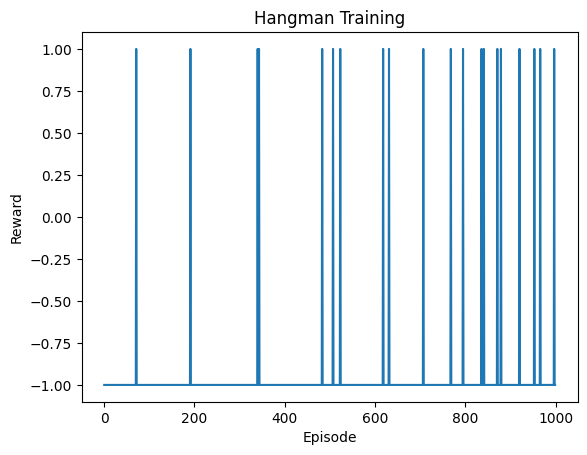


Training Complete:
Episodes: 1000
Average reward: -0.96
Max reward: 1.00
Wins: 20


In [9]:
if __name__ == "__main__":
    #ENVIRONMENT VERIFICATION
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    state, _ = env.reset()
    print(f"State shape: {state.shape}, Action space: {env.action_space.n}")
    env.close()

    #TRAINING START
    q_net, rewards_all = train_dqn(episodes=1000)

    #STATISTICS
    plt.plot(rewards_all)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Hangman Training")
    plt.show()

    print(f"\nTraining Complete:")
    print(f"Episodes: {len(rewards_all)}")
    print(f"Average reward: {np.mean(rewards_all):.2f}")
    print(f"Max reward: {np.max(rewards_all):.2f}")
    print(f"Wins: {sum(1 for r in rewards_all if r > 0)}")


In [12]:
#RECORDING VIDEOS
record_env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")

for ep_num in [70, 80, 190, 260, 270, 340, 350, 360, 500, 510, 520, 530, 540, 550, 620, 630, 640, 780, 790, 800, 870, 880, 890, 920, 950, 960, 980]:
  print(f"Recording episode {ep_num}...")
  video_file, final_reward, steps = record_episode(record_env, q_net, preprocess_state, ep_num)
  print(f"Episode {ep_num}: Reward = {final_reward}, Steps = {steps}")
  display(show_video(video_file))
  print("-" * 40)

record_env.close()

Recording episode 70...


Episode 70: Reward = -1.0, Steps = 164


----------------------------------------
Recording episode 80...


Episode 80: Reward = -1.0, Steps = 189


----------------------------------------
Recording episode 190...


Episode 190: Reward = -1.0, Steps = 179


----------------------------------------
Recording episode 260...


Episode 260: Reward = -1.0, Steps = 170


----------------------------------------
Recording episode 270...


Episode 270: Reward = -1.0, Steps = 181


----------------------------------------
Recording episode 340...


Episode 340: Reward = -1.0, Steps = 162


----------------------------------------
Recording episode 350...


Episode 350: Reward = -1.0, Steps = 161


----------------------------------------
Recording episode 360...


Episode 360: Reward = -1.0, Steps = 194


----------------------------------------
Recording episode 500...


Episode 500: Reward = -1.0, Steps = 149


----------------------------------------
Recording episode 510...


Episode 510: Reward = -1.0, Steps = 154


----------------------------------------
Recording episode 520...


Episode 520: Reward = -1.0, Steps = 185


----------------------------------------
Recording episode 530...


Episode 530: Reward = -1.0, Steps = 171


----------------------------------------
Recording episode 540...


Episode 540: Reward = 0.0, Steps = 200


----------------------------------------
Recording episode 550...


Episode 550: Reward = -1.0, Steps = 162


----------------------------------------
Recording episode 620...


Episode 620: Reward = -1.0, Steps = 174


----------------------------------------
Recording episode 630...


Episode 630: Reward = -1.0, Steps = 158


----------------------------------------
Recording episode 640...


Episode 640: Reward = -1.0, Steps = 180


----------------------------------------
Recording episode 780...


Episode 780: Reward = -1.0, Steps = 170


----------------------------------------
Recording episode 790...


Episode 790: Reward = -1.0, Steps = 173


----------------------------------------
Recording episode 800...


Episode 800: Reward = -1.0, Steps = 158


----------------------------------------
Recording episode 870...


Episode 870: Reward = -1.0, Steps = 167


----------------------------------------
Recording episode 880...


Episode 880: Reward = -1.0, Steps = 165


----------------------------------------
Recording episode 890...


Episode 890: Reward = 0.0, Steps = 200


----------------------------------------
Recording episode 920...


Episode 920: Reward = -1.0, Steps = 152


----------------------------------------
Recording episode 950...


Episode 950: Reward = -1.0, Steps = 174


----------------------------------------
Recording episode 960...


Episode 960: Reward = -1.0, Steps = 176


----------------------------------------
Recording episode 980...


Episode 980: Reward = -1.0, Steps = 174


----------------------------------------
